# TuRBO Bayesian Optimization - Safety
In this tutorial we demonstrate the use of Xopt to preform "Safety" based Trust Region Bayesian Optimization (TuRBO) on a simple test problem. During optimization of high dimensional input spaces off the shelf BO tends to over-emphasize exploration which severely degrades optimization performance. TuRBO attempts to prevent this by maintaining a surrogate model over a local (trust) region. As opposed to optimization based TuRBO, which centers the trust region on the best previously observed point, safety-based TurBO is centered on the center-of-mass location of vaild points (points that satisfy all constraints). The trust region is expanded and contracted based on the number of `successful` (observations that satisfy all constraints) or `unsuccessful` (observations that don't) observations in a row. This approach can be useful to reduce the number of constraint violations in tightly constrained parameter spaces.

## Define the test problem
Here we define a simple optimization problem, where we attempt to minimize a function in the domian [0,2*pi]. Note that the function used to evaluate the objective function takes a dictionary as input and returns a dictionary as the output. In this case we also specify a constraining function.

In [1]:
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import ExpectedImprovementGenerator
from xopt import Xopt
from xopt.vocs import VOCS
import math
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# define variables and function objectives
constraint_max = -2.
vocs = VOCS(
    variables={"x": [0, 2 * math.pi]},
    constraints={"c":["LESS_THAN", constraint_max]},
    objectives={"f": "MINIMIZE"},
)

In [2]:
# define a test function to optimize
def sin_function(input_dict):
    x = input_dict["x"]
    return {
        "f": np.sin(x),
        "c": -10 * np.exp(-((x - np.pi) ** 2) / 0.1) + 0.5 * np.sin(5 * x)
        }

## Create Xopt objects
Create the evaluator to evaluate our test function and create a generator that uses the ExpectedImprovement acquisition function to perform Bayesian Optimization. Assuming that a relatively small region of parameter space is valid, it is beneficial to start with a smaller trust region. To do that we set the initial length of the trust region to be 5% of the input domain.

In [ ]:
evaluator = Evaluator(function=sin_function)
generator = ExpectedImprovementGenerator(vocs=vocs, turbo_controller="safety")
generator.turbo_controller.length = 0.05 # set the initial trust region length scale to 5% of the range
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [4]:
X


            Xopt
________________________________
Version: 2.5.6.dev34+g34ff1b18
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: __main__.sin_function
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  custom_objective: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    custom_noise_prior: null
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_cached_hyperparameters: false
    use_low_noise_prior: true
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: expected_improvement
  numerical_optimizer:
    max_iter: 2000
    max_time: null
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller:
    batch_size: 1
    center_x: null
    dim: 1
    failure_counter: 0
    failure_tolerance: 2
    length: 0.05
    length_max: 2.0
    length_min: 0.0078

## Generate and evaluate initial points
To begin optimization, we must generate some random initial data points. The first call
to `X.step()` will generate and evaluate a number of randomly points specified by the
 generator. Note that if we add data to xopt before calling `X.step()` by assigning
 the data to `X.data`, calls to `X.step()` will ignore the random generation and
 proceed to generating points via Bayesian optimization.

In [5]:
X.evaluate_data(pd.DataFrame({"x": [2.9]}))

# inspect the gathered data
X.data

,x,f,c,xopt_runtime,xopt_error
0,2.9,0.239249,-5.111025,0.000032,False


In [6]:
# determine trust region from gathered data
X.generator.train_model()
X.generator.turbo_controller.update_state(X.generator)
X.generator.turbo_controller.get_trust_region(X.generator)

tensor([[2.7429],
        [3.0571]], dtype=torch.float64)

## Define plotting utility

In [7]:
def plot_turbo(X):
    # get the Gaussian process model from the generator
    model = X.generator.train_model()

    # get trust region
    trust_region = X.generator.turbo_controller.get_trust_region(generator).squeeze()
    scale_factor = X.generator.turbo_controller.length
    region_width = trust_region[1] - trust_region[0]

    # get number of successes and failures
    n_successes = X.generator.turbo_controller.success_counter
    n_failures = X.generator.turbo_controller.failure_counter

    # get acquisition function from generator
    acq = X.generator.get_acquisition(model)
    test_x = torch.linspace(*X.vocs.bounds.flatten(), 500).double()

    with torch.no_grad():
        posterior = model.posterior(test_x.unsqueeze(1))
        acq_val = acq(test_x.reshape(-1, 1, 1))

    # get mean function and confidence regions
    mean = posterior.mean
    l, u = posterior.mvn.confidence_region()

    # plot model and acquisition function
    fig, ax = plt.subplots(3, 1, sharex="all")

    # add title for successes and failures
    ax[0].set_title(
        f"n_successes: {n_successes}, n_failures: {n_failures}, "
        f"scale_factor: {scale_factor}, region_width: {region_width:.2}, "
    )

    # plot objective posterior
    ax[0].plot(test_x, mean[:,0],"C0", label="Objective mean")
    ax[0].fill_between(test_x, l[:,0], u[:,0], alpha=0.25, label="Confidence region")

    # plot constraint posterior
    ax[1].plot(test_x, mean[:,1],"C1", label="Constraint mean")
    ax[1].fill_between(test_x, l[:,1], u[:,1], fc="C1", alpha=0.25, label="Constraint confidence region")

    # add constraint boundary
    ax[1].axhline(constraint_max, c="C2", label="Constraint boundary")

    # add data to model plot
    ax[0].plot(X.data["x"], X.data["f"], "C0o", label="Training data")

    # add data to constraint plot
    ax[1].plot(X.data["x"], X.data["c"], "C1o", label="Training data")

    # plot true function
    ground_truth = sin_function({"x": test_x.numpy()})
    ax[0].plot(test_x, ground_truth["f"], "C0--", label="Ground truth objective")
    ax[1].plot(test_x, ground_truth["c"], "C1--", label="Ground truth constraint")

    # plot acquisition function
    ax[2].plot(test_x, acq_val.flatten().exp(), "C0", label="Acquisition function")

    ax[0].set_ylabel("f")
    ax[0].set_ylim(-1.5, 1.5)
    ax[1].set_ylabel("c")
    ax[1].set_ylim(-12, 2)
    ax[2].set_ylabel(r"$exp[\alpha(x)]$")
    ax[2].set_xlabel("x")

    # plot trust region
    for a in ax:
        a.axvline(trust_region[0], c="r", label="Trust region boundary")
        a.axvline(trust_region[1], c="r")

    # add legend
    ax[0].legend(fontsize="x-small")
    ax[1].legend(fontsize="x-small")

    fig.tight_layout()

    return fig, ax

## Do bayesian optimization steps
Notice that when the number of successive successes or failures reaches 2 the trust
region expands or contracts and counters are reset to zero. Counters are also reset
to zero during alternate successes/failures. Finally, the model is most accurate
inside the trust region, which supports our goal of local optimization.

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


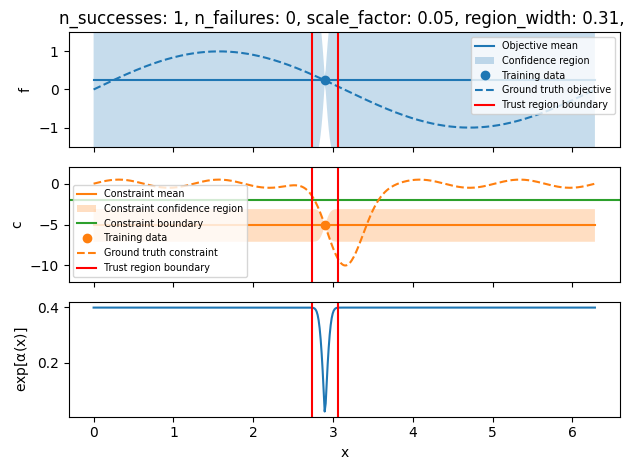

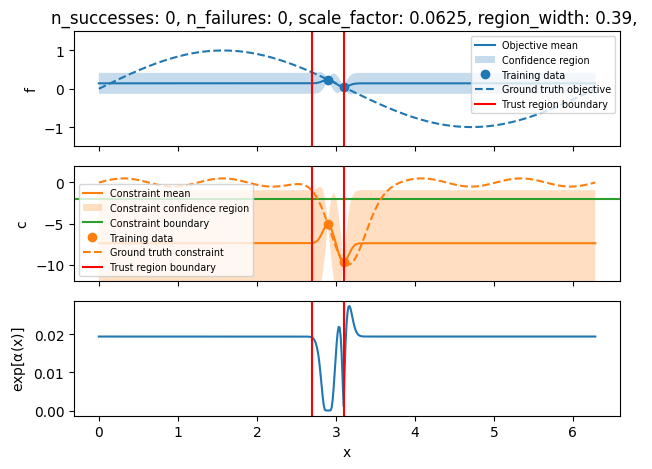

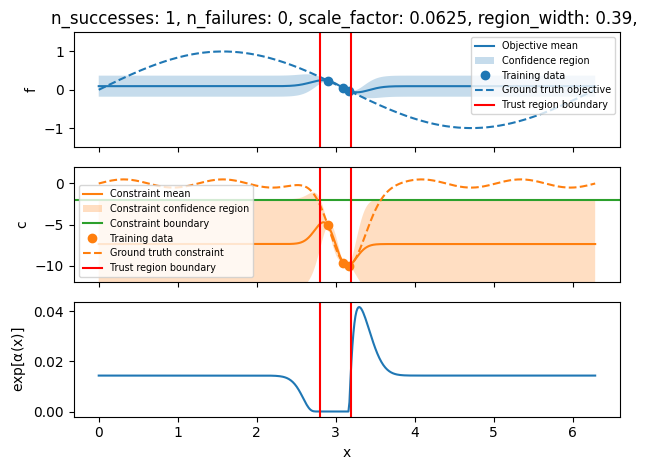

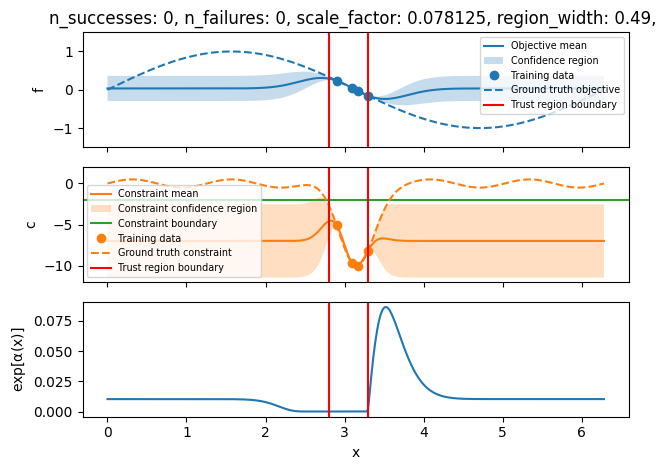

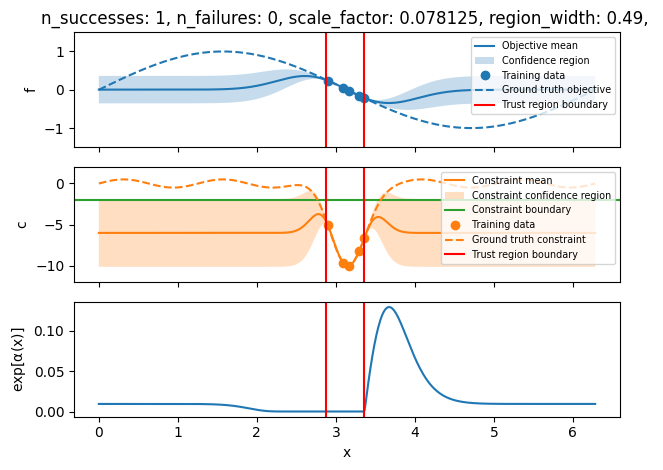

In [8]:
for i in range(5):
    # plot trust region analysis
    fig, ax = plot_turbo(X)

    # take optimization state
    X.step()

In [9]:
# access the collected data
X.generator.turbo_controller

SafetyTurboController(vocs=VOCS(variables={'x': [0.0, 6.283185307179586]}, constraints={'c': ['LESS_THAN', -2.0]}, objectives={'f': 'MINIMIZE'}, constants={}, observables=[]), dim=1, batch_size=1, length=0.09765625, length_min=0.0078125, length_max=2.0, failure_counter=0, failure_tolerance=2, success_counter=0, success_tolerance=2, center_x={'x': 3.1642095868078775}, scale_factor=1.25, restrict_model_data=True, name='SafetyTurboController', min_feasible_fraction=0.75)

In [11]:
X.data

,x,f,c,xopt_runtime,xopt_error
0,2.900000,0.239249,-5.111025,0.000032,False
1,3.096350,0.045228,-9.685241,0.000013,False
2,3.168168,-0.026572,-9.995866,0.000013,False
3,3.295971,-0.153766,-8.228197,0.000014,False
4,3.360559,-0.217221,-6.635582,0.000014,False
5,3.471006,-0.323488,-3.877126,0.000012,False
